In [37]:
import os
import json
import pandas as pd

respostas_dir = "dados/output_llms/"       
avaliacoes_dir = "dados/output/"   

def carregar_jsons(diretorio):
    arquivos = [os.path.join(diretorio, f) for f in os.listdir(diretorio) if f.endswith('.json')]
    jsons = []
    for arquivo in arquivos:
        with open(arquivo, 'r', encoding='utf-8') as f:
            try:
                dados = json.load(f)
                jsons.append(dados)
            except json.JSONDecodeError:
                print(f"Erro ao carregar: {arquivo}")
    return jsons

respostas_jsons = carregar_jsons("output_llms/")
avaliacoes_jsons = carregar_jsons("output/")

dados_combinados = []

for idx, (respostas, avaliacoes) in enumerate(zip(respostas_jsons, avaliacoes_jsons)):
    has_docstring = idx < 15  
    for llm, tipos in respostas.items():
        for tipo_prompt, codigo_gerado in tipos.items():
            aval = avaliacoes.get(llm, {}).get(tipo_prompt, {})
            dados_combinados.append({
                "llm": llm,
                "prompt_type": tipo_prompt,
                "has_docstring": has_docstring,
                "code": codigo_gerado,
                "status": aval.get("status"),
                "score": aval.get("score"),
                "coverage": aval.get("coverage", "-"),
                "assert_types": ', '.join(aval.get("assert_types", [])),
                "edge_case_found": aval.get("edge_case_found", False),
                "functions_tested": aval.get("functions_tested", 0),
                "total_functions": aval.get("total_functions", 0),
                "test_smells": json.dumps(aval.get("test_smells", {}), ensure_ascii=False),
                "stderr": aval.get("stderr", ""),
                "stdout": aval.get("stdout", "")
            })

df = pd.DataFrame(dados_combinados)
df.to_json("dataset.json", orient="records", lines=False)

code_models = {"CodeGemma", "CodeLLaMA", "WizardCoder"}
df["llm_type"] = df["llm"].apply(lambda x: "Code Model" if x in code_models else "General Model")

df

,llm,prompt_type,has_docstring,code,status,score,coverage,assert_types,edge_case_found,functions_tested,total_functions,test_smells,stderr,stdout,llm_type
0,WizardCoder,zero-shot,True,Here are some examples of unit tests to test t...,failed,0.62,-,"assertEqual, assertRaises",True,1,1,"{""magic_number"": 37}","Traceback (most recent call last):\n File ""C:...",,Code Model
1,WizardCoder,few-shot,True,Here are the unit tests for `intersperse` func...,failed,0.62,-,"assertEqual, assertRaises",True,1,1,"{""syntax_error"": 1}",C:\Users\antho\OneDrive\Área de Trabalho\testP...,Couldn't run 'C:\Users\antho\OneDrive\Área de ...,Code Model
2,WizardCoder,cot,True,"Here are the unit tests that cover edge cases,...",passed,2.67,9%,"assertEqual, assertRaises",True,1,1,"{""assertion_roulette"": 3, ""magic_number"": 24}",,,Code Model
3,CodeLLaMA,zero-shot,True,Here are some unit tests for the `intersperse`...,failed,0.55,-,assertEqual,True,1,1,"{""magic_number"": 31}",FF....\n======================================...,,Code Model
4,CodeLLaMA,few-shot,True,def test_intersperse_empty_list():\n assert...,no_code_found,0.00,-,,False,0,0,{},,,Code Model
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,Gemma,few-shot,False,```python\nimport unittest\n\nclass TestTrunca...,failed,0.22,-,"assertEqual, assertRaises",True,1,1,"{""redundant_assertion"": 2, ""magic_number"": 3, ...",.FFF.\n=======================================...,,General Model
518,Gemma,cot,False,**Step-by-step analysis:**\n\n**Edge cases:**\...,failed,0.22,-,"assertEqual, assertRaises",True,1,1,"{""magic_number"": 5, ""redundant_assertion"": 1, ...",FF...\n=======================================...,,General Model
519,CodeGemma,zero-shot,False,```python\nimport unittest\n\nclass TestTrunca...,failed,0.35,-,assertEqual,True,1,1,"{""redundant_assertion"": 2, ""magic_number"": 7}",.FF..\n=======================================...,,Code Model
520,CodeGemma,few-shot,False,```python\nimport unittest\n\nclass TestTrunca...,no_code_found,0.00,-,,False,0,0,{},,,Code Model


# RQ1

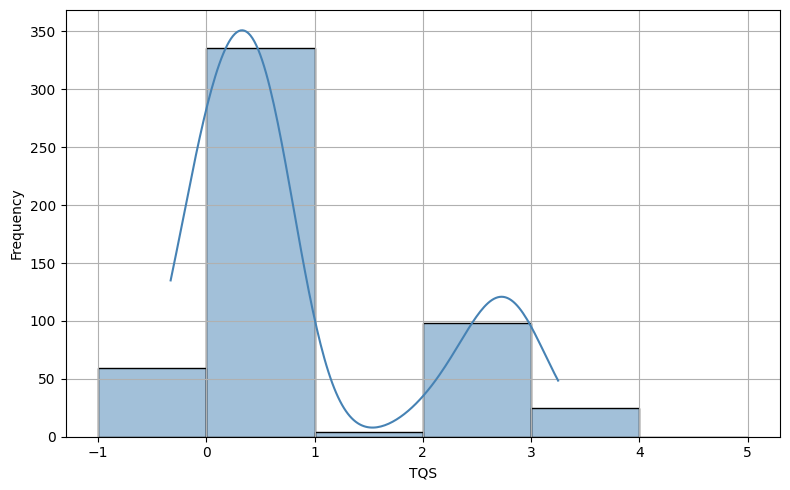

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # ← aqui está a correção

plt.figure(figsize=(8, 5))
sns.histplot(df["score"], bins=np.arange(-1, 5.5, 1), kde=True, color="steelblue")

plt.title("")
plt.xlabel("TQS")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


# RQ2

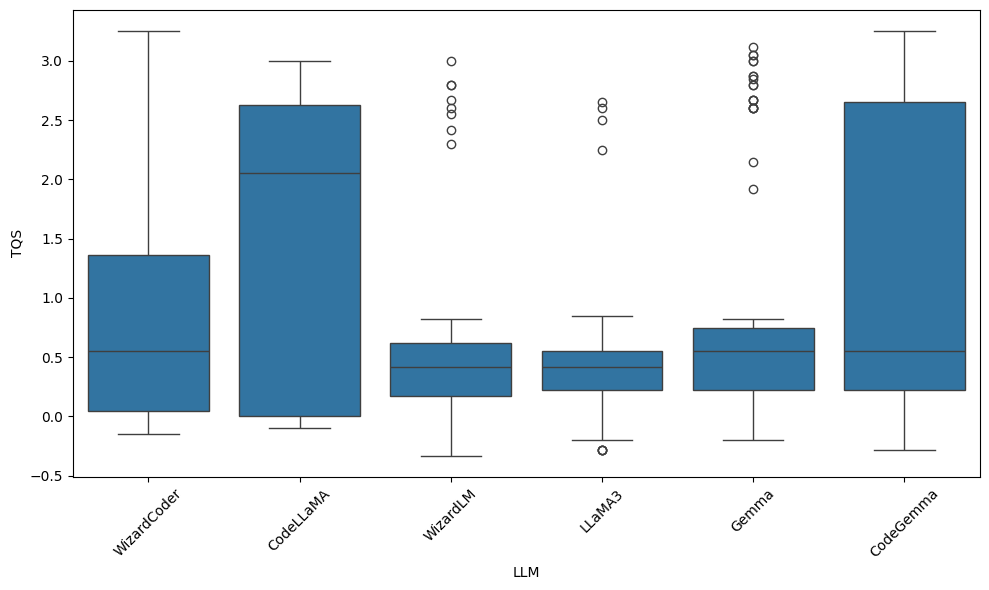

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="llm", y="score")

plt.xlabel("LLM")
plt.ylabel("TQS")
plt.title("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Victor.Alves\AppData\Local\Temp\ipykernel_13092\3231926489.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="llm_type", y="score", palette="Set2")


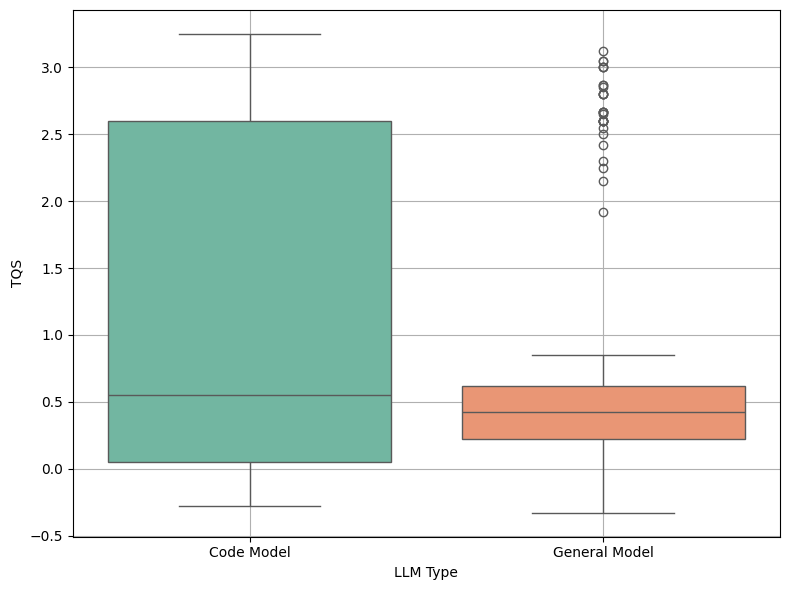

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="llm_type", y="score", palette="Set2")

plt.title("")
plt.xlabel("LLM Type")
plt.ylabel("TQS")
plt.grid(True)
plt.tight_layout()
plt.show()


# RQ3

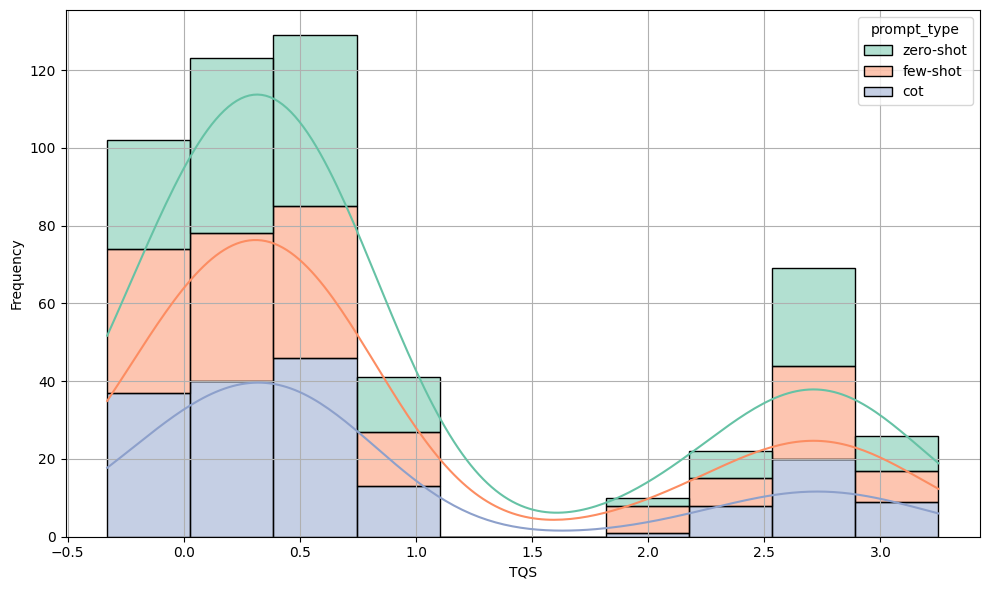

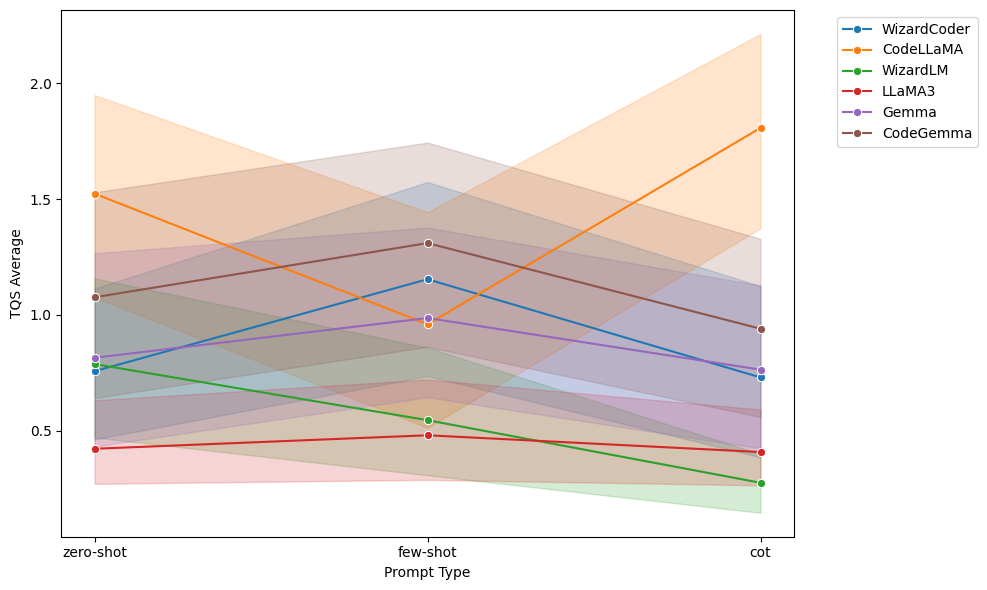

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="score", hue="prompt_type", kde=True, bins=10, palette="Set2", multiple="stack")

plt.title("")
plt.xlabel("TQS")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="prompt_type", y="score", hue="llm", marker="o")

plt.title("")
plt.xlabel("Prompt Type")
plt.ylabel("TQS Average")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# RQ4

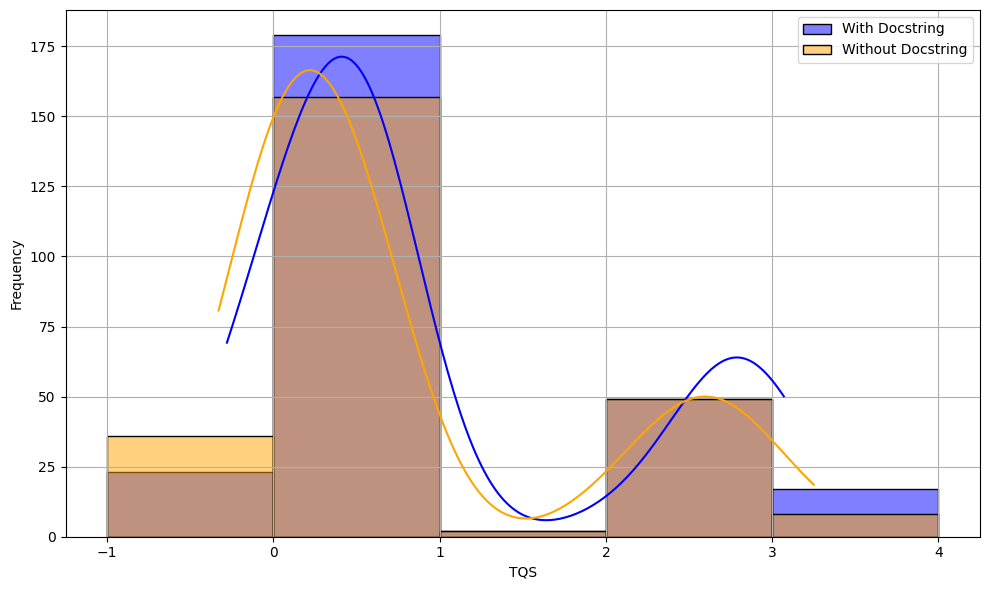

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Define bins de -1 até 4 com passo 1
bins = list(range(-1, 5))  # -1, 0, 1, 2, 3, 4

# Histograma separado por presença de docstring
sns.histplot(data=df[df["has_docstring"] == 1], x="score", bins=bins, color="blue", label="With Docstring", kde=True)
sns.histplot(data=df[df["has_docstring"] == 0], x="score", bins=bins, color="orange", label="Without Docstring", kde=True)

plt.title("")
plt.xlabel("TQS")
plt.ylabel("Frequency")
plt.xticks(bins)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
